In [1]:


df = labdataranger.graph.query.dataframe(
    query = f"""
    MATCH (s:Scan)-[]-(f:Folder)
    WHERE f.name CONTAINS '_Rec'
    MATCH (r:Reconstruction)-[]-(s:Scan)-[]-(a:Acquisition)
    WHERE s.filepath CONTAINS 'LaraM_Full_Dataset'
    RETURN f.name, s.filepath, a.studyDateAndTime, r.timeAndDate
    """, 
    database='instruments',
    column_map={
    'f.name': 'Name',
    's.filepath': 'Filepath',
    'a.studyDateAndTime': 'Acquired',
    'r.timeAndDate': 'Reconstructed'
    }, verbose=True
) 

Results for query: 
    MATCH (s:Scan)-[]-(f:Folder)
    WHERE f.name CONTAINS '_Rec'
    MATCH (r:Reconstruction)-[]-(...
          Name                                           Filepath  \
0       1L_Rec  /mnt/data/archive/LaraM_Full_Dataset/U37/10_21...   
1       1R_Rec  /mnt/data/archive/LaraM_Full_Dataset/U37/10_21...   
2       NP_Rec  /mnt/data/archive/LaraM_Full_Dataset/U37/10_21...   
3       1L_Rec  /mnt/data/archive/LaraM_Full_Dataset/U37/10_21...   
4       1R_Rec  /mnt/data/archive/LaraM_Full_Dataset/U37/10_21...   
...        ...                                                ...   
2760  2660_Rec  /mnt/data/archive/LaraM_Full_Dataset/02.3.22_7...   
2761  2674_Rec  /mnt/data/archive/LaraM_Full_Dataset/02.3.22_7...   
2762  2933_Rec  /mnt/data/archive/LaraM_Full_Dataset/02.3.22_7...   
2763  2932_Rec  /mnt/data/archive/LaraM_Full_Dataset/02.3.22_7...   
2764    NP_Rec  /mnt/data/archive/LaraM_Full_Dataset/U37/10_21...   

                      Acquired           Reconst

In [2]:
def split_path(fp, root_path='/mnt/data/archive/LaraM_Full_Dataset'):
    return fp.replace(root_path, '', 1).strip('/').split('/')

df['fp_split'] = df['Filepath'].apply(lambda x: split_path(x))


def extract_study_labels(folder_list):
    # Use a list comprehension to find matches that start with 'U' or 'u' followed by numbers
    # return list(set([entry.upper() for entry in folder_list if re.match(r'[Uu]\d+', entry)]))
    matches = [match.group() for entry in folder_list for match in re.finditer(r'[Uu]\d+', entry)]
    return list(set([match.upper() for match in matches]))


df['Studies'] = df['fp_split'].apply(lambda x: extract_study_labels(x))

print()
print(df['Studies'].apply(lambda x: len(x)).value_counts())
print()

overlaps = df['Studies'][df['Studies'].apply(lambda x: len(x)) > 1].reset_index(drop=True).value_counts()
print(overlaps)

import networkx as nx

# Create an empty graph
G = nx.Graph()

# Add edges between all elements in each row's list
for study_list in overlaps.index:
    for i in range(len(study_list)):
        for j in range(i + 1, len(study_list)):
            G.add_edge(study_list[i], study_list[j])

# Find connected components
connected_components = list(nx.connected_components(G))

print()
# Display the connected components
for i, component in enumerate(connected_components, 1):
    print(f"Cluster {i}: {sorted(component)}")

print()

no_study = df[['Filepath', 'fp_split']][df['Studies'].apply(lambda x: len(x)) == 0]
print(no_study['fp_split'].apply(lambda x: x[:1]).value_counts())
print()
print(no_study['fp_split'].apply(lambda x: x[:2]).value_counts())
print()


1    2173
0     322
2     207
3      63
Name: Studies, dtype: int64

[U20, U25]         61
[U19, U20]         41
[U23, U22, U20]    32
[U23, U18, U22]    31
[U25, U20]         31
[U23, U22]         30
[U26, U20]         27
[U26, U27]         13
[U16, U19]          4
Name: Studies, dtype: int64

Cluster 1: ['U16', 'U18', 'U19', 'U20', 'U22', 'U23', 'U25', 'U26', 'U27']

[05.09.22_SW_organoids]    35
[05.23.22_SW_organoids]    34
[6.9.22_SW_organoids]      34
[1.4.22_SW]                25
[3.28.22_SW]               25
[02.27.22_SW]              23
[03.02.22_SW]              18
[08.10.21_SW]              18
[02.3.22_740_SW]           12
[08.30.21_sw]              11
[07.26.21_SW]              10
[07.30.21_sw]              10
[07.23.21_sw]              10
[09.24.21_SW_USGI]         10
[08.18.21_SW]               9
[10.21.21_SW]               6
[10.07.21_SW]               6
[11.18.21_SW_USGI]          6
[11.3.21_SW]                6
[04.16.21_SW]               5
[070521]                   

In [3]:


def date_pattern_generator(verbose=False):
    # List of delimiters to use in date patterns, including no delimiter (empty string)
    delimiters = ['', '-', '_', r'\.']
    
    # List of common date component sequences (order matters for date format)
    date_components = [
        ['\d{4}', '\d{2}', '\d{2}'],  # YYYYMMDD
        ['\d{2}', '\d{2}', '\d{4}'],  # DDMMYYYY
        ['\d{2}', '\d{2}', '\d{2}'],  # YYMMDD or DDMMYY
        ['\d{2}', '\d{2}', '\d{4}'],  # MMDDYYYY
        ['\d{4}', '\d{2}', '\d{2}'],  # YYYYDDMM (less common)
        ['\d{1}', '\d{1}', '\d{2}'],  # DMYY
        ['\d{1}', '\d{2}', '\d{2}'],  # DMMYY
        ['\d{2}', '\d{1}', '\d{2}'],  # DDMYY
    ]
    
    # Generate the list of regex patterns using the delimiters and date components
    date_patterns = []
    for delimiter in delimiters:
        # Create the regex string based on the delimiter and date components
        for components in date_components:
            pattern = delimiter.join(components)
            date_patterns.append(pattern)
    
    # Print the generated date patterns for verification
    if verbose:
        for pattern in date_patterns:
            print(pattern)

    return date_patterns


# Define the function to scan and clean date labels matching common date patterns
def extract_date_labels(folder_list):
    # Generate date patterns
    date_patterns = date_pattern_generator()
    
    # Use a set to keep unique date matches
    matches = set()
    
    for entry in folder_list:
        for pattern in date_patterns:
            matches.update(re.findall(pattern, entry))
    
    # Remove redundant matches (where one is a substring of another)
    matches = list(matches)
    matches.sort(key=len, reverse=True)  # Sort by length, longest first
    
    # Filter out substrings
    non_redundant_matches = []
    for i, match in enumerate(matches):
        if not any(match in longer_match for longer_match in matches[:i]):
            non_redundant_matches.append(match)
    
    return non_redundant_matches


# Apply the function to the DataFrame column
df['Dates'] = df['fp_split'].apply(lambda x: extract_date_labels(x))

# Print results
print("Dates Found")
print(df['Dates'].apply(lambda x: len(x)).value_counts())
print()

Dates Found
1    2235
2     410
0     117
3       3
Name: Dates, dtype: int64



In [4]:

import re


def date_pattern_generator(verbose=False):
    delimiters = ['', '-', '_', r'\.']
    date_components = [
        ['\d{4}', '\d{2}', '\d{2}'],  # YYYYMMDD
        ['\d{2}', '\d{2}', '\d{4}'],  # DDMMYYYY
        ['\d{2}', '\d{2}', '\d{2}'],  # YYMMDD or DDMMYY
        ['\d{2}', '\d{2}', '\d{4}'],  # MMDDYYYY
        ['\d{4}', '\d{2}', '\d{2}'],  # YYYYDDMM (less common)
        ['\d{1}', '\d{1}', '\d{2}'],  # DMYY
        ['\d{1}', '\d{2}', '\d{2}'],  # DMMYY
        ['\d{2}', '\d{1}', '\d{2}'],  # DDMYY
    ]
    
    date_patterns = []
    for delimiter in delimiters:
        for components in date_components:
            pattern = delimiter.join(components)
            date_patterns.append(pattern)
    
    if verbose:
        for pattern in date_patterns:
            print(pattern)

    return date_patterns

def is_valid_date(date_str):
    formats = ['%Y-%m-%d', '%d-%m-%Y', '%y-%m-%d', '%d-%m-%y',
               '%m-%d-%Y', '%Y.%m.%d', '%d.%m.%Y', '%y.%m.%d',
               '%d.%m.%y', '%m.%d.%Y', '%Y_%m_%d', '%d_%m_%Y',
               '%y_%m_%d', '%d_%m_%y', '%m_%d_%Y', '%Y%m%d']
    
    for fmt in formats:
        try:
            parsed_date = datetime.strptime(date_str, fmt)
            if 1900 <= parsed_date.year <= 2100:
                return True
        except ValueError:
            continue
    return False

def extract_date_labels(folder_list):
    date_patterns = date_pattern_generator()
    matches = set()
    for entry in folder_list:
        for pattern in date_patterns:
            matches.update(re.findall(pattern, entry))
    
    # Filter matches to ensure only valid dates remain
    matches = [match for match in matches if is_valid_date(match)]
    matches.sort(key=len, reverse=True)
    
    non_redundant_matches = []
    for i, match in enumerate(matches):
        if not any(match in longer_match for longer_match in matches[:i]):
            non_redundant_matches.append(match)
    
    return non_redundant_matches

# # Sample DataFrame for testing
# data = {
#     'fp_split': [
#         ['path/to/1.2.22/file.txt', 'another/path/1234/file.txt'],
#         ['2023-05-01', 'some/dir/2023.05.01'],
#         ['file_2022_11_30', 'dir/22-11-30'],
#         ['02.3.22_740_SW', 'cage 90', '2660', '2660_Rec']
#     ]
# }
# df = pd.DataFrame(data)

# Apply the function to the DataFrame column
df['Dates'] = df['fp_split'].apply(lambda x: extract_date_labels(x))

# Print results
print("Dates Found")
print(df['Dates'].apply(lambda x: len(x)).value_counts())
print(df[['fp_split', 'Dates']])

Dates Found
0    1706
1    1059
Name: Dates, dtype: int64
                                        fp_split         Dates
0          [U37, 10_21_2022, Cage 6, 1L, 1L_Rec]  [10_21_2022]
1          [U37, 10_21_2022, Cage 6, 1R, 1R_Rec]  [10_21_2022]
2          [U37, 10_21_2022, Cage 8, NP, NP_Rec]  [10_21_2022]
3          [U37, 10_21_2022, Cage 8, 1L, 1L_Rec]  [10_21_2022]
4          [U37, 10_21_2022, Cage 8, 1R, 1R_Rec]  [10_21_2022]
...                                          ...           ...
2760   [02.3.22_740_SW, cage 90, 2660, 2660_Rec]     [02.3.22]
2761   [02.3.22_740_SW, cage 90, 2674, 2674_Rec]     [02.3.22]
2762  [02.3.22_740_SW, cage 112, 2933, 2933_Rec]     [02.3.22]
2763  [02.3.22_740_SW, cage 112, 2932, 2932_Rec]     [02.3.22]
2764       [U37, 10_21_2022, Cage 6, NP, NP_Rec]  [10_21_2022]

[2765 rows x 2 columns]


In [5]:
df['Dates'][df['Dates'].apply(lambda x: len(x) > 0)]

0       [10_21_2022]
1       [10_21_2022]
2       [10_21_2022]
3       [10_21_2022]
4       [10_21_2022]
            ...     
2760       [02.3.22]
2761       [02.3.22]
2762       [02.3.22]
2763       [02.3.22]
2764    [10_21_2022]
Name: Dates, Length: 1059, dtype: object

In [6]:
df[df['Dates'].apply(lambda x: len(x) == 0)]

,Name,Filepath,Acquired,Reconstructed,fp_split,Studies,Dates
21,1R_c61R_Rec,/mnt/data/archive/LaraM_Full_Dataset/U29_10152...,15 Oct 2022 16h:42m:32s,"Oct 15, 2022 16:44:42","[U29_101522, CTRL, 1R_c61R_Rec]",[U29],[]
22,NP_c2NP_Rec,/mnt/data/archive/LaraM_Full_Dataset/U29_10152...,15 Oct 2022 16h:37m:56s,"Oct 15, 2022 16:39:30","[U29_101522, CTRL, NP_c2NP_Rec]",[U29],[]
23,1L_c71L_Rec,/mnt/data/archive/LaraM_Full_Dataset/U29_10152...,15 Oct 2022 16h:34m:02s,"Oct 15, 2022 16:35:54","[U29_101522, CTRL, 1L_c71L_Rec]",[U29],[]
24,1L1R_c51L_Rec,/mnt/data/archive/LaraM_Full_Dataset/U29_10152...,15 Oct 2022 16h:29m:55s,"Oct 15, 2022 16:32:46","[U29_101522, CTRL, 1L1R_c51L_Rec]",[U29],[]
25,2L_c22L_Rec,/mnt/data/archive/LaraM_Full_Dataset/U29_10152...,15 Oct 2022 17h:04m:12s,"Oct 15, 2022 17:10:45","[U29_101522, IL12, 2L_c22L_Rec]",[U29],[]
...,...,...,...,...,...,...,...
2728,2L_Rec,/mnt/data/archive/LaraM_Full_Dataset/1.27.22_S...,27 Jan 2022 11h:26m:28s,"Jan 27, 2022 11:28:46","[1.27.22_SW, u22, cage 1, 2L, 2L_Rec]",[U22],[]
2729,0_Rec,/mnt/data/archive/LaraM_Full_Dataset/1.27.22_S...,27 Jan 2022 11h:12m:57s,"Jan 27, 2022 11:15:54","[1.27.22_SW, u22, cage 1, 0, 0_Rec]",[U22],[]
2730,2R_Rec,/mnt/data/archive/LaraM_Full_Dataset/1.27.22_S...,27 Jan 2022 11h:09m:35s,"Jan 27, 2022 11:11:21","[1.27.22_SW, u22, cage 1, 2R, 2R_Rec]",[U22],[]
2731,2L_Rec,/mnt/data/archive/LaraM_Full_Dataset/1.27.22_S...,27 Jan 2022 10h:58m:39s,"Jan 27, 2022 11:00:43","[1.27.22_SW, u20_cage 4, 2L, 2L_Rec]",[U20],[]


In [7]:
df['Acquired']

0       21 Oct 2022  12h:22m:32s
1       21 Oct 2022  11h:10m:52s
2       21 Oct 2022  11h:49m:26s
3       21 Oct 2022  11h:41m:05s
4       21 Oct 2022  11h:36m:44s
                  ...           
2760    03 Feb 2022  12h:42m:13s
2761    03 Feb 2022  12h:38m:32s
2762    03 Feb 2022  13h:13m:29s
2763    03 Feb 2022  13h:18m:42s
2764    21 Oct 2022  12h:30m:37s
Name: Acquired, Length: 2765, dtype: object

In [8]:

from datetime import datetime

# Function to scan and format the date from the 'Acquired' column
def extract_acquisition_date(acquired_str):
    try:
        # Extract only the date part and parse it
        date_part = acquired_str.split('  ')[0]  # Split at double space and take the first part
        parsed_date = datetime.strptime(date_part, '%d %b %Y')  # Parse with the format 'DD Mon YYYY'
        return parsed_date.strftime('%Y-%m-%d')  # Return as 'YYYY-MM-DD'
    except (ValueError, IndexError):
        return None  # Return None if parsing fails

# Apply the function to create the 'Dates' column and check for invalid entries
df['Date'] = df['Acquired'].apply(extract_acquisition_date)

# Identify rows with invalid dates
invalid_dates = df[df['Dates'].isnull()]

# Print results
print("Extracted Dates")
print(df[['Acquired', 'Dates']])
print("\nEntries with invalid dates:")
print(invalid_dates[['Acquired']])

Extracted Dates
                      Acquired         Dates
0     21 Oct 2022  12h:22m:32s  [10_21_2022]
1     21 Oct 2022  11h:10m:52s  [10_21_2022]
2     21 Oct 2022  11h:49m:26s  [10_21_2022]
3     21 Oct 2022  11h:41m:05s  [10_21_2022]
4     21 Oct 2022  11h:36m:44s  [10_21_2022]
...                        ...           ...
2760  03 Feb 2022  12h:42m:13s     [02.3.22]
2761  03 Feb 2022  12h:38m:32s     [02.3.22]
2762  03 Feb 2022  13h:13m:29s     [02.3.22]
2763  03 Feb 2022  13h:18m:42s     [02.3.22]
2764  21 Oct 2022  12h:30m:37s  [10_21_2022]

[2765 rows x 2 columns]

Entries with invalid dates:
Empty DataFrame
Columns: [Acquired]
Index: []


In [9]:
df

,Name,Filepath,Acquired,Reconstructed,fp_split,Studies,Dates,Date
0,1L_Rec,/mnt/data/archive/LaraM_Full_Dataset/U37/10_21...,21 Oct 2022 12h:22m:32s,"Oct 21, 2022 12:26:49","[U37, 10_21_2022, Cage 6, 1L, 1L_Rec]",[U37],[10_21_2022],2022-10-21
1,1R_Rec,/mnt/data/archive/LaraM_Full_Dataset/U37/10_21...,21 Oct 2022 11h:10m:52s,"Oct 21, 2022 11:17:07","[U37, 10_21_2022, Cage 6, 1R, 1R_Rec]",[U37],[10_21_2022],2022-10-21
2,NP_Rec,/mnt/data/archive/LaraM_Full_Dataset/U37/10_21...,21 Oct 2022 11h:49m:26s,"Oct 21, 2022 11:52:29","[U37, 10_21_2022, Cage 8, NP, NP_Rec]",[U37],[10_21_2022],2022-10-21
3,1L_Rec,/mnt/data/archive/LaraM_Full_Dataset/U37/10_21...,21 Oct 2022 11h:41m:05s,"Oct 21, 2022 11:43:28","[U37, 10_21_2022, Cage 8, 1L, 1L_Rec]",[U37],[10_21_2022],2022-10-21
4,1R_Rec,/mnt/data/archive/LaraM_Full_Dataset/U37/10_21...,21 Oct 2022 11h:36m:44s,"Oct 21, 2022 11:40:04","[U37, 10_21_2022, Cage 8, 1R, 1R_Rec]",[U37],[10_21_2022],2022-10-21
...,...,...,...,...,...,...,...,...
2760,2660_Rec,/mnt/data/archive/LaraM_Full_Dataset/02.3.22_7...,03 Feb 2022 12h:42m:13s,"Feb 03, 2022 12:44:19","[02.3.22_740_SW, cage 90, 2660, 2660_Rec]",[],[02.3.22],2022-02-03
2761,2674_Rec,/mnt/data/archive/LaraM_Full_Dataset/02.3.22_7...,03 Feb 2022 12h:38m:32s,"Feb 03, 2022 12:41:00","[02.3.22_740_SW, cage 90, 2674, 2674_Rec]",[],[02.3.22],2022-02-03
2762,2933_Rec,/mnt/data/archive/LaraM_Full_Dataset/02.3.22_7...,03 Feb 2022 13h:13m:29s,"Feb 03, 2022 13:15:07","[02.3.22_740_SW, cage 112, 2933, 2933_Rec]",[],[02.3.22],2022-02-03
2763,2932_Rec,/mnt/data/archive/LaraM_Full_Dataset/02.3.22_7...,03 Feb 2022 13h:18m:42s,"Feb 03, 2022 13:20:21","[02.3.22_740_SW, cage 112, 2932, 2932_Rec]",[],[02.3.22],2022-02-03


In [10]:
df['Date'].value_counts()

2022-04-12    73
2022-05-06    50
2022-05-12    50
2022-10-05    50
2022-04-06    47
              ..
2022-01-18     2
2022-01-10     2
2022-01-03     2
2022-02-01     2
2020-03-02     1
Name: Date, Length: 135, dtype: int64

In [11]:
# Function to scan the 'Cage' group
def extract_cage_group(folder_list):
    for entry in folder_list:
        # Regular expression to match 'Cage' followed by a number, case insensitive
        match = re.search(r'\bcage\s+(\d+)\b', entry, re.IGNORECASE)
        if match:
            return f"Cage{int(match.group(1)):03d}"  # Standardize to 'Cage $number'
    return None  # Return None if no match is found

# Apply the function to create the 'Cage' column
df['Cage'] = df['fp_split'].apply(lambda x: extract_cage_group(x))

# Print results
print("Extracted Cage Groups")
print(df[['fp_split', 'Cage']])

Extracted Cage Groups
                                        fp_split     Cage
0          [U37, 10_21_2022, Cage 6, 1L, 1L_Rec]  Cage006
1          [U37, 10_21_2022, Cage 6, 1R, 1R_Rec]  Cage006
2          [U37, 10_21_2022, Cage 8, NP, NP_Rec]  Cage008
3          [U37, 10_21_2022, Cage 8, 1L, 1L_Rec]  Cage008
4          [U37, 10_21_2022, Cage 8, 1R, 1R_Rec]  Cage008
...                                          ...      ...
2760   [02.3.22_740_SW, cage 90, 2660, 2660_Rec]  Cage090
2761   [02.3.22_740_SW, cage 90, 2674, 2674_Rec]  Cage090
2762  [02.3.22_740_SW, cage 112, 2933, 2933_Rec]  Cage112
2763  [02.3.22_740_SW, cage 112, 2932, 2932_Rec]  Cage112
2764       [U37, 10_21_2022, Cage 6, NP, NP_Rec]  Cage006

[2765 rows x 2 columns]


In [12]:
df

,Name,Filepath,Acquired,Reconstructed,fp_split,Studies,Dates,Date,Cage
0,1L_Rec,/mnt/data/archive/LaraM_Full_Dataset/U37/10_21...,21 Oct 2022 12h:22m:32s,"Oct 21, 2022 12:26:49","[U37, 10_21_2022, Cage 6, 1L, 1L_Rec]",[U37],[10_21_2022],2022-10-21,Cage006
1,1R_Rec,/mnt/data/archive/LaraM_Full_Dataset/U37/10_21...,21 Oct 2022 11h:10m:52s,"Oct 21, 2022 11:17:07","[U37, 10_21_2022, Cage 6, 1R, 1R_Rec]",[U37],[10_21_2022],2022-10-21,Cage006
2,NP_Rec,/mnt/data/archive/LaraM_Full_Dataset/U37/10_21...,21 Oct 2022 11h:49m:26s,"Oct 21, 2022 11:52:29","[U37, 10_21_2022, Cage 8, NP, NP_Rec]",[U37],[10_21_2022],2022-10-21,Cage008
3,1L_Rec,/mnt/data/archive/LaraM_Full_Dataset/U37/10_21...,21 Oct 2022 11h:41m:05s,"Oct 21, 2022 11:43:28","[U37, 10_21_2022, Cage 8, 1L, 1L_Rec]",[U37],[10_21_2022],2022-10-21,Cage008
4,1R_Rec,/mnt/data/archive/LaraM_Full_Dataset/U37/10_21...,21 Oct 2022 11h:36m:44s,"Oct 21, 2022 11:40:04","[U37, 10_21_2022, Cage 8, 1R, 1R_Rec]",[U37],[10_21_2022],2022-10-21,Cage008
...,...,...,...,...,...,...,...,...,...
2760,2660_Rec,/mnt/data/archive/LaraM_Full_Dataset/02.3.22_7...,03 Feb 2022 12h:42m:13s,"Feb 03, 2022 12:44:19","[02.3.22_740_SW, cage 90, 2660, 2660_Rec]",[],[02.3.22],2022-02-03,Cage090
2761,2674_Rec,/mnt/data/archive/LaraM_Full_Dataset/02.3.22_7...,03 Feb 2022 12h:38m:32s,"Feb 03, 2022 12:41:00","[02.3.22_740_SW, cage 90, 2674, 2674_Rec]",[],[02.3.22],2022-02-03,Cage090
2762,2933_Rec,/mnt/data/archive/LaraM_Full_Dataset/02.3.22_7...,03 Feb 2022 13h:13m:29s,"Feb 03, 2022 13:15:07","[02.3.22_740_SW, cage 112, 2933, 2933_Rec]",[],[02.3.22],2022-02-03,Cage112
2763,2932_Rec,/mnt/data/archive/LaraM_Full_Dataset/02.3.22_7...,03 Feb 2022 13h:18m:42s,"Feb 03, 2022 13:20:21","[02.3.22_740_SW, cage 112, 2932, 2932_Rec]",[],[02.3.22],2022-02-03,Cage112


In [13]:
def join_study_names(x):
    x = '_'.join(x)
    if len(x) > 0:
        return x
    else:
        return 'TBD'

df['Study'] = df['Studies'].apply(lambda x: join_study_names(x))

In [14]:
df['Individual'] = df['Name'].str.replace('_Rec', '')

In [15]:
df[['Study','Cage','Individual','Date']]

,Study,Cage,Individual,Date
0,U37,Cage006,1L,2022-10-21
1,U37,Cage006,1R,2022-10-21
2,U37,Cage008,NP,2022-10-21
3,U37,Cage008,1L,2022-10-21
4,U37,Cage008,1R,2022-10-21
...,...,...,...,...
2760,TBD,Cage090,2660,2022-02-03
2761,TBD,Cage090,2674,2022-02-03
2762,TBD,Cage112,2933,2022-02-03
2763,TBD,Cage112,2932,2022-02-03


In [18]:
import pandas as pd
import os

# # Sample DataFrame to demonstrate
# data = {
#     'Study': ['Study1', 'Study2', None, 'Study3'],
#     'Cage': ['Cage 6', 'Cage 90', 'Cage 112', None],
#     'Individual': ['Mouse1', 'Mouse2', 'Mouse3', 'Mouse4'],
#     'Date': ['2022-10-21', '2022-10-21', '2022-10-22', None]
# }
# df = pd.DataFrame(data)

# Function to create folder paths
def create_folder_structure(df, base_path='base_directory'):
    folder_paths = []
    for _, row in df.iterrows():
        # Replace None or NaN with 'Unknown'
        study = row['Study'] if pd.notna(row['Study']) else 'Unknown'
        cage = row['Cage'] if pd.notna(row['Cage']) else 'Unknown'
        individual = row['Individual'] if pd.notna(row['Individual']) else 'Unknown'
        date = row['Date'] if pd.notna(row['Date']) else 'Unknown'
        
        # Construct the folder path
        folder_path = os.path.join(base_path, study, cage, individual, date)
        folder_paths.append(folder_path)
        
        # Optionally, create the directories on the filesystem
        # os.makedirs(folder_path, exist_ok=True)
    
    # Add the new paths to the DataFrame for visualization
    df['FolderPath'] = folder_paths
    return df

# Apply the function to create the folder paths
df = create_folder_structure(df, base_path="LauraM_USGI")

# Print the result
print(df[['Study', 'Cage', 'Individual', 'Date', 'FolderPath']])


     Study     Cage Individual        Date  \
0      U37  Cage006         1L  2022-10-21   
1      U37  Cage006         1R  2022-10-21   
2      U37  Cage008         NP  2022-10-21   
3      U37  Cage008         1L  2022-10-21   
4      U37  Cage008         1R  2022-10-21   
...    ...      ...        ...         ...   
2760   TBD  Cage090       2660  2022-02-03   
2761   TBD  Cage090       2674  2022-02-03   
2762   TBD  Cage112       2933  2022-02-03   
2763   TBD  Cage112       2932  2022-02-03   
2764   U37  Cage006         NP  2022-10-21   

                                   FolderPath  
0       LauraM_USGI/U37/Cage006/1L/2022-10-21  
1       LauraM_USGI/U37/Cage006/1R/2022-10-21  
2       LauraM_USGI/U37/Cage008/NP/2022-10-21  
3       LauraM_USGI/U37/Cage008/1L/2022-10-21  
4       LauraM_USGI/U37/Cage008/1R/2022-10-21  
...                                       ...  
2760  LauraM_USGI/TBD/Cage090/2660/2022-02-03  
2761  LauraM_USGI/TBD/Cage090/2674/2022-02-03  
2762  LauraM_US

In [33]:
fp_map = df[['Filepath','FolderPath']].copy()

fp_map.rename(columns={
    'Filepath': 'source',
    'FolderPath': 'target'
}, inplace=True)

fp_map['source'].value_counts()

/mnt/data/archive/LaraM_Full_Dataset/U37/10_21_2022/Cage 6/1L/1L_Rec            1
/mnt/data/archive/LaraM_Full_Dataset/12.15.21_SW_U22_U23/U22/1/1R/1R_Rec        1
/mnt/data/archive/LaraM_Full_Dataset/12.15.21_SW_U22_U23/U23/2/0/0_Rec          1
/mnt/data/archive/LaraM_Full_Dataset/12.15.21_SW_U22_U23/U23/2/2R/2R_Rec        1
/mnt/data/archive/LaraM_Full_Dataset/12.15.21_SW_U22_U23/U22/3/1L/1L_Rec        1
                                                                               ..
/mnt/data/archive/LaraM_Full_Dataset/20.12.21_SW_U20_U22_U23/U23/3/1L/1L_Rec    1
/mnt/data/archive/LaraM_Full_Dataset/20.12.21_SW_U20_U22_U23/U23/3/1R/1R_Rec    1
/mnt/data/archive/LaraM_Full_Dataset/20.12.21_SW_U20_U22_U23/U23/3/2L/2L_Rec    1
/mnt/data/archive/LaraM_Full_Dataset/20.12.21_SW_U20_U22_U23/U23/3/0/0_Rec      1
/mnt/data/archive/LaraM_Full_Dataset/U37/10_21_2022/Cage 6/NP/NP_Rec            1
Name: source, Length: 2765, dtype: int64

In [34]:
fp_map['target'].value_counts()

LauraM_USGI/TBD/Unknown/0/2021-07-26     10
LauraM_USGI/TBD/Unknown/0/2021-07-23     10
LauraM_USGI/TBD/Unknown/0/2021-07-30     10
LauraM_USGI/TBD/Unknown/0/2021-08-10     10
LauraM_USGI/U17/Unknown/1L/2021-06-25     7
                                         ..
LauraM_USGI/U51/Cage001/1L/2023-04-24     1
LauraM_USGI/U51/Cage001/1R/2023-04-24     1
LauraM_USGI/U51/Cage001/2L/2023-04-24     1
LauraM_USGI/U51/Cage001/2R/2023-04-24     1
LauraM_USGI/U37/Cage006/NP/2022-10-21     1
Name: target, Length: 2399, dtype: int64

In [35]:
# Group the sources by the target and create a list of sources for each target
grouped_fp_map = fp_map.groupby('target')['source'].apply(list).reset_index()

# Rename columns for clarity
grouped_fp_map.rename(columns={'source': 'source_list'}, inplace=True)

# Print the result
print(grouped_fp_map)

                                                 target  \
0                  LauraM_USGI/TBD/Cage001/0/2021-08-18   
1                  LauraM_USGI/TBD/Cage001/0/2022-02-27   
2                  LauraM_USGI/TBD/Cage001/0/2022-05-09   
3                  LauraM_USGI/TBD/Cage001/0/2022-05-23   
4                  LauraM_USGI/TBD/Cage001/0/2022-06-09   
...                                                 ...   
2394             LauraM_USGI/U9/Unknown/2617/2021-05-07   
2395             LauraM_USGI/U9/Unknown/2617/2021-05-27   
2396             LauraM_USGI/U9/Unknown/2617/2021-07-08   
2397         LauraM_USGI/U9/Unknown/no tag 1/2021-05-07   
2398  LauraM_USGI/U9/Unknown/no tag in cage 26_2/202...   

                                            source_list  
0     [/mnt/data/archive/LaraM_Full_Dataset/08.18.21...  
1     [/mnt/data/archive/LaraM_Full_Dataset/02.27.22...  
2     [/mnt/data/archive/LaraM_Full_Dataset/05.09.22...  
3     [/mnt/data/archive/LaraM_Full_Dataset/05.23.22...  
4

In [63]:
len(grouped_fp_map[grouped_fp_map['source_list'].apply(lambda x: len(x) == 0)]), \
len(grouped_fp_map[grouped_fp_map['source_list'].apply(lambda x: len(x) == 1)]), \
len(grouped_fp_map[grouped_fp_map['source_list'].apply(lambda x: len(x) >= 2)])

(0, 2228, 171)

In [ ]:
multi_source = grouped_fp_map[grouped_fp_map['source_list'].apply(lambda x: len(x) >= 2)]
multi_source.reset_index(inplace=True, drop=True)
ambiguous = multi_source['source_list'].explode().reset_index(drop=True)
ambiguous = pd.DataFrame(ambiguous).rename(columns={'source_list': 'Filepath'})
merged_df = pd.merge(ambiguous, df, on='Filepath', how='inner')
merged_df[['Filepath','Acquired', 'Study', 'Cage', 'Date', 'Individual']].to_csv('ambiguous.csv', index=False)

In [67]:
single_source = grouped_fp_map[grouped_fp_map['source_list'].apply(lambda x: len(x) == 1)]
single_source.reset_index(inplace=True, drop=True)
one_to_one = single_source['source_list'].explode().reset_index(drop=True)
one_to_one = pd.DataFrame(one_to_one).rename(columns={'source_list': 'Filepath'})
merged_df = pd.merge(one_to_one, df, on='Filepath', how='inner')
merged_df[['Filepath','Acquired', 'Study', 'Cage', 'Date', 'Individual']].to_csv('mapped.csv', index=False)

In [68]:
meta = merged_df[['Filepath','Acquired', 'Study', 'Cage', 'Date', 'Individual']].copy()

In [70]:
meta.columns

Index(['Filepath', 'Acquired', 'Study', 'Cage', 'Date', 'Individual'], dtype='object')

In [188]:
substr='-'
# Identify rows in the specified columns containing '-'
for col in meta[['Study','Cage','Individual']].columns:
    contains_dash = meta[col].str.contains(substr, na=False)
    if contains_dash.any():
        print(f"\nEntries in column '{col}' containing '-':")
        print(meta.loc[contains_dash, col])

meta[['Study', 'Cage', 'Individual']] = meta[['Study','Cage','Individual']].applymap(lambda x: str(x).replace(' ', '_') if isinstance(x, str) else x)
meta['UID'] = meta[['Study','Cage','Individual']].astype(str).agg('-'.join, axis=1)
meta.to_csv('uid_')

,Filepath,Acquired,Study,Cage,Date,Individual,UID
0,/mnt/data/archive/LaraM_Full_Dataset/02.27.22_...,27 Feb 2022 12h:09m:07s,TBD,Cage001,2022-02-27,0,TBD-Cage001-0
1,/mnt/data/archive/LaraM_Full_Dataset/05.09.22_...,09 May 2022 10h:07m:23s,TBD,Cage001,2022-05-09,0,TBD-Cage001-0
2,/mnt/data/archive/LaraM_Full_Dataset/05.23.22_...,23 May 2022 13h:07m:10s,TBD,Cage001,2022-05-23,0,TBD-Cage001-0
3,/mnt/data/archive/LaraM_Full_Dataset/6.9.22_SW...,09 Jun 2022 12h:32m:44s,TBD,Cage001,2022-06-09,0,TBD-Cage001-0
4,/mnt/data/archive/LaraM_Full_Dataset/070521/ca...,07 May 2021 13h:14m:17s,TBD,Cage001,2021-05-07,0082,TBD-Cage001-0082
...,...,...,...,...,...,...,...
2223,/mnt/data/archive/LaraM_Full_Dataset/U9/070521...,07 May 2021 13h:02m:22s,U9,None,2021-05-07,2617,U9-None-2617
2224,/mnt/data/archive/LaraM_Full_Dataset/U9/U9_052...,27 May 2021 14h:35m:13s,U9,None,2021-05-27,2617,U9-None-2617
2225,/mnt/data/archive/LaraM_Full_Dataset/U9/070821...,08 Jul 2021 16h:06m:42s,U9,None,2021-07-08,2617,U9-None-2617
2226,/mnt/data/archive/LaraM_Full_Dataset/U9/070521...,07 May 2021 12h:46m:58s,U9,None,2021-05-07,no_tag_1,U9-None-no_tag_1


In [189]:
import numpy as np


In [194]:
print(np.__version__)

1.26.0


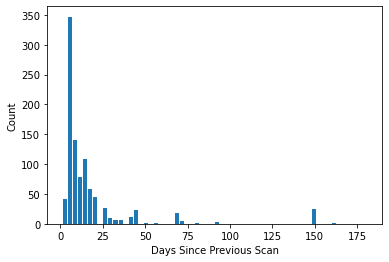

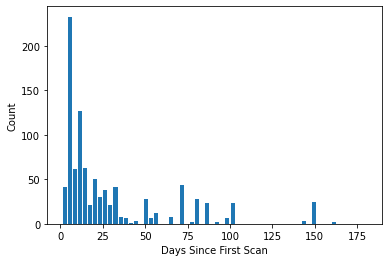

In [197]:
dates = meta[['UID', 'Date']].copy()
dates = dates.groupby('UID')['Date'].agg(list).reset_index()
multidate = dates[dates['Date'].apply(lambda x: len(x) > 1)].copy()

multidate['Date'] = multidate['Date'].apply(lambda x: pd.to_datetime(x))
multidate['DaysSincePrevious'] = multidate['Date'].apply(lambda x: [(x[i+1] - x[i]).days for i in range(len(x) - 1)])
multidate['DaysSinceFirst'] = multidate['Date'].apply(lambda x: [(x[i] - x[0]).days for i in range(1, len(x))])

plt.hist(multidate['DaysSincePrevious'].explode(), rwidth=0.8, range=[1,181], bins=60)
# plt.loglog()
plt.ylabel('Count')
plt.xlabel('Days Since Previous Scan')
plt.show()

plt.hist(multidate['DaysSinceFirst'].explode(), rwidth=0.8, range=[1,181], bins=60)
# plt.loglog()
plt.ylabel('Count')
plt.xlabel('Days Since First Scan')
plt.show()

In [196]:
multidate.to_csv('dates_by_subject.csv', index=False)

In [98]:
uid_counts = count_by_uid.to_dict()

In [100]:
uid_counts.values()

dict_values([7, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

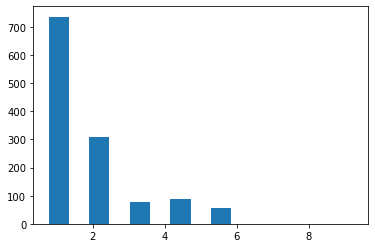

In [109]:
import matplotlib.pyplot as plt


plt.hist(uid_counts.values(), range=[0.5,9.5], bins=8, rwidth=0.5)
plt.show()

In [ ]:
def query_graph(query, config_file='db_config.json', database='neo4j', verbose=False):
    with open(config_file, 'r') as file:
        config = json.load(file)
    
    uri = config.get("uri")
    username = config.get("username")
    password = config.get("password")
    database = config.get("database", database)

    driver = GraphDatabase.driver(uri, auth=(username, password))
    graph = nx.Graph()
    with driver.session(database=database) as session:
        result = session.run(query)
        for record in result:
            if verbose:
                print(f"  {record}")

            for key, value in record.items():
                if isinstance(value, dict):  # Node
                    graph.add_node(value['id'], **value)
                elif isinstance(value, tuple):  # Relationship
                    start_node, relationship, end_node = value
                    graph.add_node(start_node['id'], **start_node)
                    graph.add_node(end_node['id'], **end_node)
                    graph.add_edge(start_node['id'], end_node['id'], **relationship)

    driver.close()
    
    return graph

# Example usage:
graph_result = query_graph(
    f"""
    MATCH (fp:Folder)-[cf:CONTAINS_FOLDER]->(fc:Folder)
    RETURN fp, cf, fc
    """, database='instruments', verbose=True
)

# Printing nodes and edges of the graph
print("Nodes:")
for node in graph_result.nodes(data=True):
    print(node)

print("\nEdges:")
for edge in graph_result.edges(data=True):
    print(edge)

In [1]:


import neo4j

_c = labdataranger.graph.query.get_db_config()
uri = _c.get("uri")
username = _c.get("username")
password = _c.get("password")
database = 'instruments'

with neo4j.GraphDatabase.driver(uri, auth=(username, password)) as driver:
    graph_result = driver.execute_query(
        """
            MATCH (fp:Folder)-[cf:CONTAINS_FOLDER]->(fc:Folder)
            RETURN fp, cf, fc
        """, 
        database_=database,
        result_transformer_=neo4j.Result.graph)

import pyvis
import networkx as nx

def visualize_result(query_graph, nodes_text_properties):
    visual_graph = pyvis.network.Network(directed=True)

    for node in query_graph.nodes:
        node_label = list(node.labels)[0]
        node_text = node[nodes_text_properties[node_label]]
        visual_graph.add_node(node.element_id, node_text, group=node_label)

    for relationship in query_graph.relationships:
        visual_graph.add_edge(
            relationship.start_node.element_id,
            relationship.end_node.element_id,
            title=relationship.type
        )

    visual_graph.show('network.html', notebook=False)
    
    return visual_graph

nodes_text_properties = {
    "Folder": "folder"
}
pyvis_graph = visualize_result(graph_result, nodes_text_properties)

G = nx.nx_agraph.from_agraph(pyvis_graph)

network.html


AttributeError: 'Network' object has no attribute 'graph_attr'

In [10]:
pyvis_graph.

True

In [11]:
pyvis_graph.

<bound method Network.toggle_stabilization of <class 'pyvis.network.Network'> |N|=7001 |E|=7,000>

In [ ]:
! pip install 